In [1]:
import pyodbc
import pandas as pd
from dotenv import load_dotenv
import os
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

In [2]:
# kết nối đén sql server
load_dotenv()
server = os.getenv('SERVER')
database = os.getenv('DATABASE')

if server is None or database is None:
    print("Please set the environment variables 'SERVER' and 'DATABASE'")
    exit()

try:
    # Kết nối đến cơ sở dữ liệu
    connection = pyodbc.connect(
        'DRIVER={ODBC Driver 17 for SQL Server};SERVER=' + server + 
        ';DATABASE=' + database + 
        ';Trusted_Connection=yes;'
    )

    collection = 'pudgypenguins'
    query_collection = f"SELECT * FROM collections WHERE collection_slug = '{collection}'"
    query_nfts = f"SELECT * FROM nfts_infor WHERE collection = '{collection}'"
    query_transactions = f"""SELECT t.* FROM transaction_infor t 
                                JOIN nfts_infor n ON t.name = n.name 
                                WHERE n.collection = '{collection}'"""
    

    df_collection = pd.read_sql(query_collection,connection)
    if df_collection.empty:
        print("No data in collection")
    df_nfts = pd.read_sql(query_nfts, connection)
    if df_nfts.empty:
        print("No data in nfts")
    df_transactions = pd.read_sql(query_transactions, connection)
    if df_transactions.empty:
        print("No data in transactions")

    # Đóng kết nối
    connection.close()
except pyodbc.Error as ex:
    print("Error connecting to database:", ex)


C:\Users\ADMIN\AppData\Local\Temp\ipykernel_4572\2103086568.py:26: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_collection = pd.read_sql(query_collection,connection)
C:\Users\ADMIN\AppData\Local\Temp\ipykernel_4572\2103086568.py:29: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_nfts = pd.read_sql(query_nfts, connection)
C:\Users\ADMIN\AppData\Local\Temp\ipykernel_4572\2103086568.py:32: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_transactions = pd.read_sql(query_transactions, connection)


In [3]:
df_collection

,collection_slug,name,owner,contracts_address
0,pudgypenguins,Pudgy Penguins,0xf54c9a0e44a5f5afd27c7ac8a176a843b9114f1d,0xbd3531da5cf5857e7cfaa92426877b022e612cf8


In [4]:
# những cột của df_nfts
df_nfts.columns

Index(['tokenid', 'name', 'owners_address', 'collection', 'quantity',
       'update_date', 'update_time'],
      dtype='object')

In [5]:
# df_nfts chua cac thong tin ve nft cua 1 collection
# phân bố nắm giữ
df_owners = df_nfts.groupby('owners_address')[['quantity']].sum().sort_values(by ='quantity', ascending= False)
# tỷ lệ phân bổ của những token này
df_owners['owned'] = df_owners['quantity']/ df_owners['quantity'].sum()*100
df_owners['owned'] = df_owners['owned'].round(2)

df_owners.head(10)

,quantity,owned
owners_address,,
0x29469395eaf6f95920e59f858042f0e28d98a20b,307,3.45
0x3f22fc93143790a1bd11c37c65a0a0f7e7875ea2,161,1.81
0x6138d1073b63e33b97771a4ab8b361617d6b53c3,93,1.05
0x3eb879cc9a0ef4c6f1d870a40ae187768c278da2,71,0.80
0x4182a46c61c3ee40e61304f8b419f813eeced3b4,68,0.77
0x796b157c2a4f01663934b04cc11e61a920711d32,45,0.51
0x29f1abd903f2293d062307d1ff4e25697a05986f,41,0.46
0x0000000044638842d0e30f6ff587cd99650526fa,39,0.44
0xfdd6cc8f6849e82f5e0102057fa74941024d11b6,39,0.44


In [6]:
# Địa chỉ ví của người tạo ra
creator_address = df_collection['owner'].iloc[0]

# Loc những nft thuộc chủ sở hữu
creator_nfts = df_nfts[df_nfts['owners_address'] == creator_address]

# Tính toán số lượng nft 
num_nft_creator = creator_nfts['quantity'].sum()
num_nft_others = df_nfts['quantity'].sum() - num_nft_creator

# In kết quả
print("Số lượng NFT của creator:", num_nft_creator)
print("Số lượng NFT của những người còn lại:", num_nft_others)

Số lượng NFT của creator: 0
Số lượng NFT của những người còn lại: 8887


In [7]:
# tính số lượng người nắm giữ 1, 2-3,4-10, 11+
owned_1 = df_owners[df_owners['quantity'] == 1].shape[0]
owned_2_3 = df_owners[(df_owners['quantity'] >= 2) & (df_owners['quantity'] <= 3)].shape[0]
owned_4_10 = df_owners[(df_owners['quantity'] >= 4) & (df_owners['quantity'] <= 10)].shape[0]
owned_11_plus = df_owners[(df_owners['quantity'] >= 11)].shape[0]
total_quantity = df_owners['quantity'].sum()

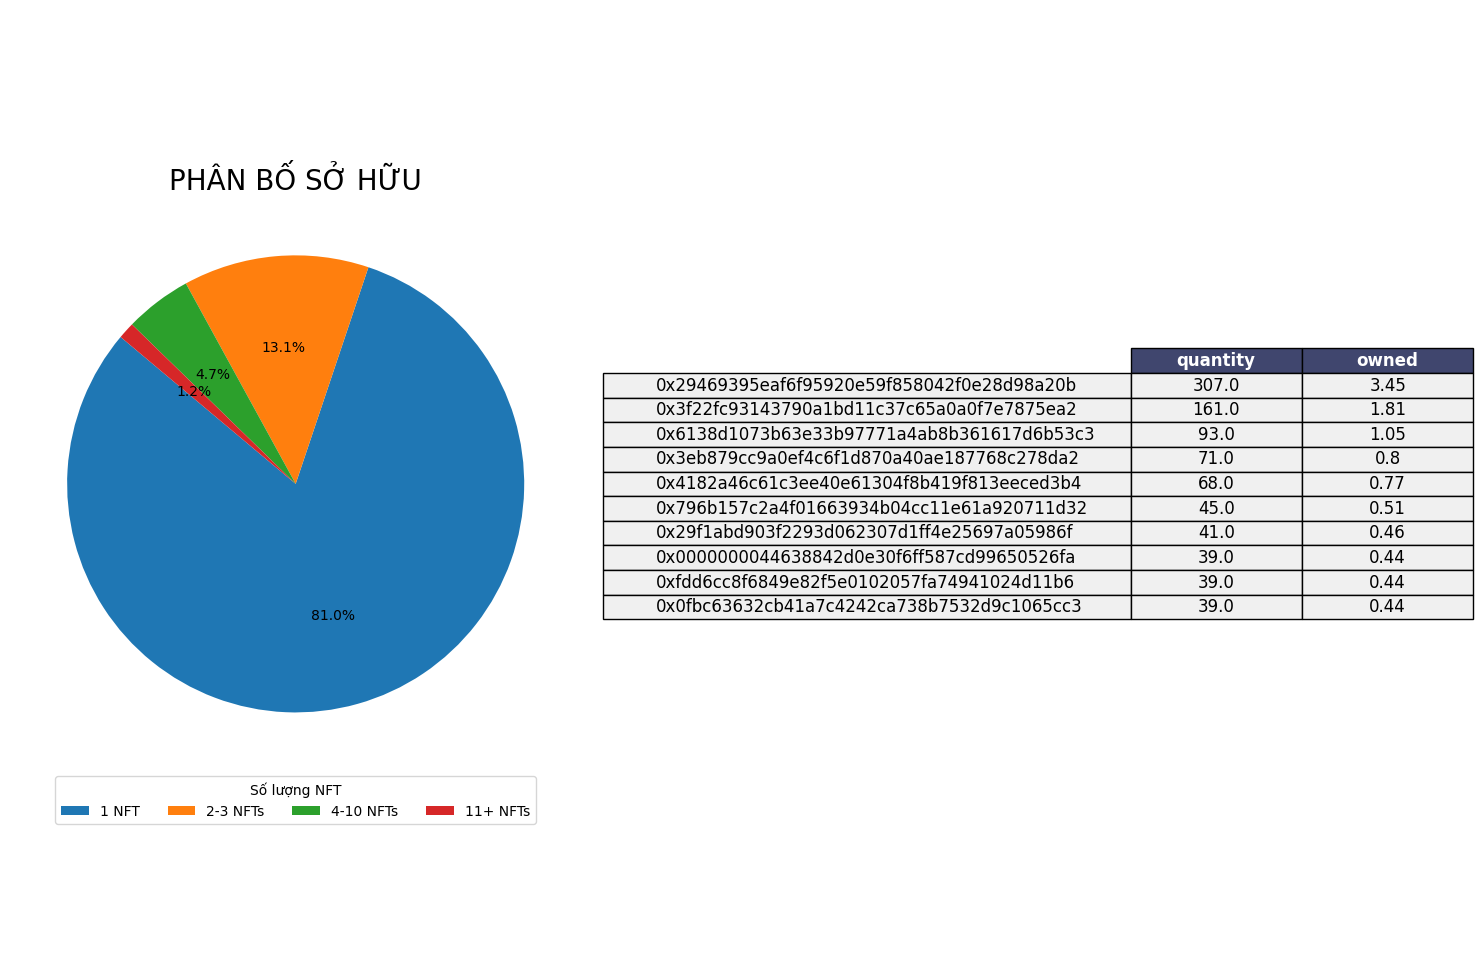

In [8]:
# Create figure and GridSpec
fig = plt.figure(figsize=(15, 10))
gs = GridSpec(1, 2, figure=fig, width_ratios=[4, 2])

# Add subplots
ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1])

# Data for pie chart
labels = ["1 NFT", "2-3 NFTs", "4-10 NFTs", "11+ NFTs"]
percentages = [
    (owned_1 / total_quantity) * 100,
    (owned_2_3 / total_quantity) * 100,
    (owned_4_10 / total_quantity) * 100,
    (owned_11_plus / total_quantity) * 100,
]

# Plot pie chart
wedges, texts, autotexts = ax1.pie(
    percentages, labels=None, autopct="%1.1f%%", startangle=140
)

# Add legend to pie chart
ax1.legend(wedges, labels, title="Số lượng NFT", loc="upper center", bbox_to_anchor=(0.5, 0), ncol=4)

# Set title for pie chart
ax1.set_title("PHÂN BỐ SỞ HỮU", fontsize=20)

# Top 10 owners table
top_10_owners = df_owners.head(10)
ax2.axis('off')
table1 = ax2.table(
    rowLabels=top_10_owners.index,
    cellText=top_10_owners.values,
    colLabels=top_10_owners.columns,
    cellLoc='center',
    loc='center'
)

# Customize table appearance
table1.auto_set_font_size(False)
table1.set_fontsize(12)
table1.scale(1.2, 1.2)

for key, cell in table1.get_celld().items():
    cell.set_edgecolor('black')
    cell.set_linewidth(1)
    cell.set_facecolor('#f0f0f0')
    if key[0] == 0:
        cell.set_text_props(weight='bold', color='white')
        cell.set_facecolor('#40466e')

# Set title for table
# ax2.set_title('TOP NGƯỜI SƠ HỮU NFT', fontsize=20, pad=5, loc='center')

# Display the figure
plt.tight_layout()
plt.show()

In [9]:
# biến động giá trong 1 tuần gần nhất
date_max = df_transactions['time'].dt.date.max()
date_min = date_max - pd.Timedelta(days=6)

df_a_week = df_transactions[(df_transactions['time'].dt.date <= date_max) & (df_transactions['time'].dt.date >= date_min)]
# sắp xếp df_a_week theo thời gian tăng dần
df_a_week = df_a_week.sort_values(by='time')

# Tính toán cho người bán nhiều nhất trong 1 tuần
total_transactions = df_a_week['transaction'].count()
df_seller = pd.DataFrame()
df_seller['count'] = df_a_week.groupby('seller')['transaction'].count()
df_seller['ratio'] = df_seller['count'] / total_transactions * 100
df_seller['ratio'] = df_seller['ratio'].round(2)  # Làm tròn đến 2 chữ số thập phân
df_seller = df_seller.sort_values(by='ratio', ascending=False).head(10)

# Tính toán cho người mua nhiều nhất trong 1 tuần
df_buyer = pd.DataFrame()
df_buyer['count'] = df_a_week.groupby('buyer')['transaction'].count()
df_buyer['ratio'] = df_buyer['count'] / total_transactions * 100
df_buyer['ratio'] = df_buyer['ratio'].round(2)  # Làm tròn đến 2 chữ số thập phân
df_buyer = df_buyer.sort_values(by='ratio', ascending=False).head(10)

# tính toán giá trung bình và khối lượng
df_tran_week = df_a_week[['time', 'price']]
df_tran_week['time'] = df_tran_week['time'].dt.date
df_week_avg = df_tran_week.groupby('time').agg(avg_price=('price', 'mean'), volume=('price', 'sum')).reset_index()

C:\Users\ADMIN\AppData\Local\Temp\ipykernel_4572\3131355760.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_tran_week['time'] = df_tran_week['time'].dt.date


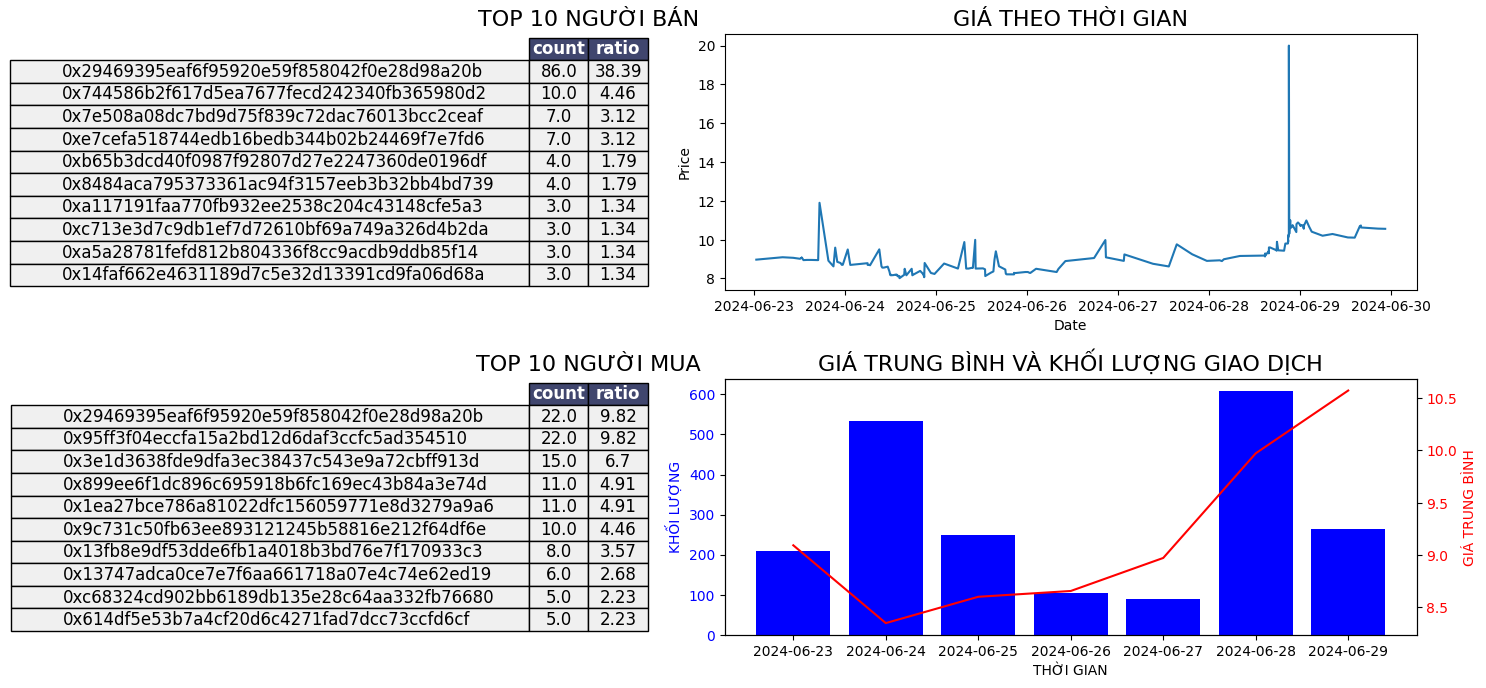

In [10]:
# Sử dụng GridSpec để tạo layout cho bảng và biểu đồ
fig = plt.figure(figsize=(15, 10))
gs = GridSpec(3, 2, width_ratios=[1, 7], figure=fig)

ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[1, 0])
ax3 = fig.add_subplot(gs[1, 1])
ax4 = fig.add_subplot(gs[0, 1])

# # Hiển thị giao động giá
ax4.plot(df_a_week['time'], df_a_week['price'])
ax4.set_title('GIÁ THEO THỜI GIAN',fontsize =16)
ax4.set_xlabel('Date')
ax4.set_ylabel('Price')

# Hiển thị bảng seller và buyer
# seller
ax1.axis('off')
table1 = ax1.table(rowLabels=df_seller.index, cellText=df_seller.values, colLabels=df_seller.columns, cellLoc='center', loc='center')
table1.auto_set_font_size(False)
table1.set_fontsize(12)
table1.scale(1.2, 1.2)

for key, cell in table1.get_celld().items():
    cell.set_edgecolor('black')
    cell.set_linewidth(1)
    cell.set_facecolor('#f0f0f0')
    if key[0] == 0:
        cell.set_text_props(weight='bold', color='white')
        cell.set_facecolor('#40466e')
ax1.set_title('TOP 10 NGƯỜI BÁN',fontsize =16)

#   buyer table
ax2.axis('off')
table2 = ax2.table(rowLabels=df_buyer.index, cellText=df_buyer.values, colLabels=df_buyer.columns, cellLoc='center', loc='center')
table2.auto_set_font_size(False)
table2.set_fontsize(12)
table2.scale(1.2, 1.2)

# Customize the cell appearance
for key, cell in table2.get_celld().items():
    cell.set_edgecolor('black')
    cell.set_linewidth(1)
    cell.set_facecolor('#f0f0f0')
    if key[0] == 0:
        cell.set_text_props(weight='bold', color='white')
        cell.set_facecolor('#40466e')
ax2.set_title('TOP 10 NGƯỜI MUA',fontsize =16)


# Vẽ biểu đồ giá trung bình và khối lượng giao dịch
ax5 = ax3.twinx()

ax3.bar(df_week_avg['time'], df_week_avg['volume'], color='b', label='Avg Volume')
ax5.plot(df_week_avg['time'], df_week_avg['avg_price'], color='r', label='Avg Price')

ax3.set_xlabel('THỜI GIAN')
ax3.set_ylabel('KHỐI LƯỢNG', color='b')
ax5.set_ylabel('GIÁ TRUNG BÌNH', color='r')

ax3.tick_params(axis='y', labelcolor='b')
ax5.tick_params(axis='y', labelcolor='r')

ax3.set_title('GIÁ TRUNG BÌNH VÀ KHỐI LƯỢNG GIAO DỊCH',fontsize =16)

fig.tight_layout()
plt.show()


C:\Users\ADMIN\AppData\Local\Temp\ipykernel_4572\3316919584.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_all['time'] = pd.to_datetime(df_all['time']).dt.date


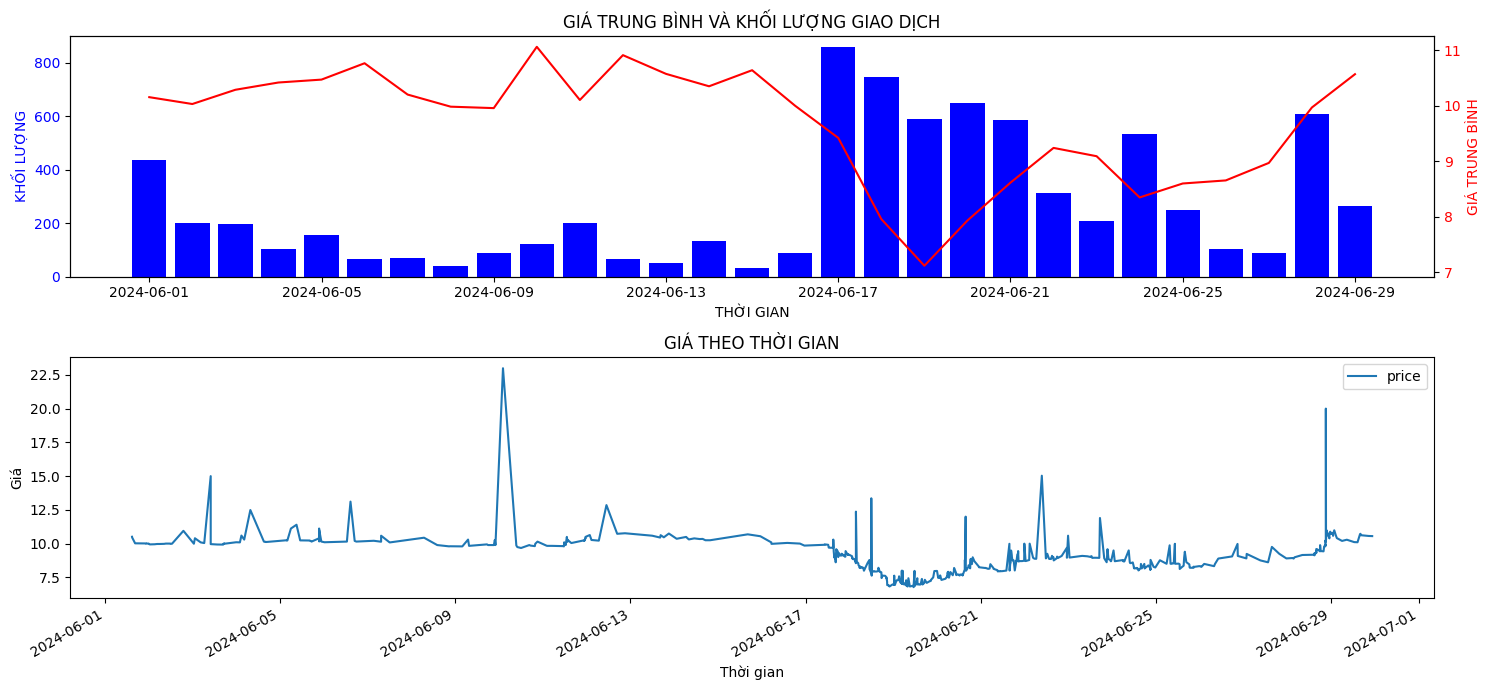

In [11]:
# tính khối lượng và giá trung bình
df_all = df_transactions[['time', 'price']]
df_all['time'] = pd.to_datetime(df_all['time']).dt.date
df_all_avg = df_all.groupby('time').agg(avg_price=('price', 'mean'), volume=('price', 'sum')).reset_index()

#tạo biểu đồ
fig, axs = plt.subplots(2, 1, figsize=(12, 10))

# biểu đồ giá trung bình và khối lượng
ax1 = axs[0]
ax2 = ax1.twinx()

ax1.bar(df_all_avg['time'], df_all_avg['volume'], color='b', label='Avg Volume')
ax2.plot(df_all_avg['time'], df_all_avg['avg_price'], color='r', label='Avg Price')

ax1.set_xlabel('THỜI GIAN')
ax1.set_ylabel('KHỐI LƯỢNG', color='b')
ax2.set_ylabel('GIÁ TRUNG BÌNH', color='r')

ax1.tick_params(axis='y', labelcolor='b')
ax2.tick_params(axis='y', labelcolor='r')

ax1.set_title('GIÁ TRUNG BÌNH VÀ KHỐI LƯỢNG GIAO DỊCH')

# sắp xếp các trannsaction theo thời gian
df_transactions = df_transactions.sort_values(by='time')

#biểu đồ giá theo thời gian
df_transactions.plot(y='price', x='time', title='GIÁ THEO THỜI GIAN', ylabel='Giá', xlabel='Thời gian', figsize=(15, 7), ax=axs[1])

fig.tight_layout()
plt.show()


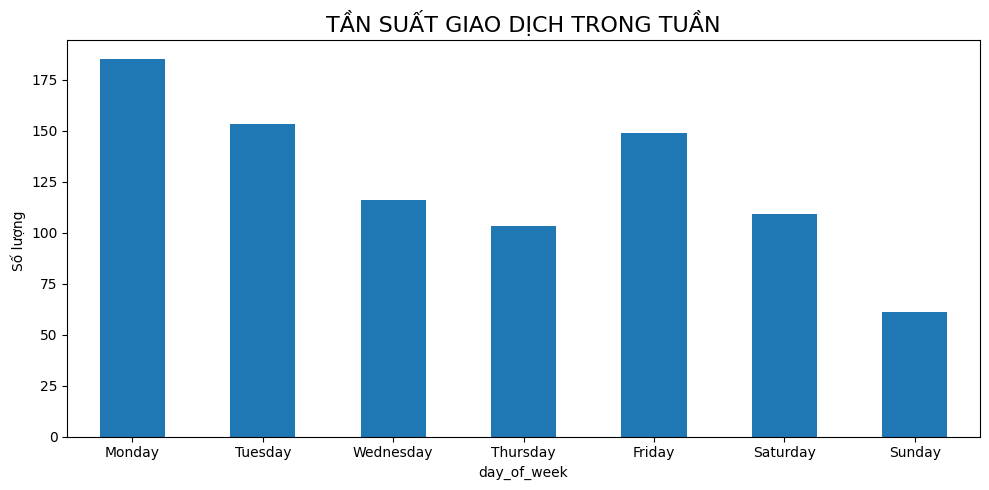

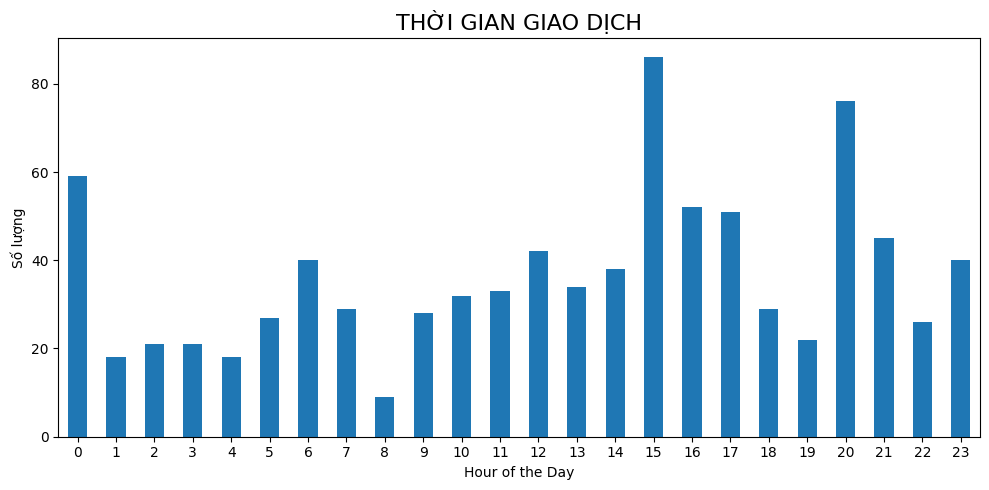

In [12]:
df = pd.DataFrame(df_transactions)
# Convert 'time' to datetime
df['date_time'] = pd.to_datetime(df['time'])

df['hour'] = df['date_time'].dt.hour
df['day_of_week'] = df['date_time'].dt.day_name()

# Transactions by Day of the Week
plt.figure(figsize=(10, 5))
day_counts = df['day_of_week'].value_counts().reindex(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
day_counts.plot(kind='bar')
plt.title('TẦN SUẤT GIAO DỊCH TRONG TUẦN',fontsize =16)
plt.ylabel('Số lượng ')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

# Transactions by Hour of the Day
plt.figure(figsize=(10, 5))
hour_counts = df['hour'].value_counts().sort_index()
hour_counts.plot(kind='bar')
plt.title('THỜI GIAN GIAO DỊCH',fontsize =16)
plt.xlabel('Hour of the Day')
plt.ylabel('Số lượng')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

In [13]:
# Dữ liệu transaction bạn cung cấp chứa thông tin về việc mua bán các NFT từ bộ sưu tập "Pudgy Penguins" trên blockchain Ethereum. Dưới đây là một số phân tích có thể giúp bạn đưa ra quyết định đầu tư:

# 1. **Giá và Biến Động**: Giá mua của hai NFT là khoảng 10.74 ETH và 10.73 ETH. Việc so sánh giá này với giá các NFT khác trong cùng bộ sưu tập có thể cho thấy mức độ hấp dẫn của chúng so với thị trường chung.

# 2. **Các Nhà Mua Bán Thường Xuyên**: Cả hai giao dịch đều có cùng một người mua (`0x29469395eaf6f95920e59f858042f0e28d98a20b`). Điều này có thể chỉ ra rằng người này đang tập trung thu thập các NFT từ bộ sưu tập này, có thể do đánh giá cao tiềm năng tăng giá hoặc chỉ đơn giản là yêu thích bộ sưu tập.

# 3. **Mức Độ Hoạt Động của Bộ Sưu Tập**: Tần suất và khối lượng các giao dịch trong bộ sưu tập "Pudgy Penguins" có thể cung cấp thông tin về mức độ phổ biến và sự quan tâm của thị trường đối với bộ sưu tập này.

# 4. **Thời Điểm Giao Dịch**: Cả hai giao dịch diễn ra rất gần nhau về mặt thời gian. Việc phân tích thời điểm các giao dịch có thể giúp nhận diện xu hướng mua vào hoặc bán ra trong ngắn hạn.

# Dựa vào các phân tích trên, bạn có thể quyết định đầu tư dựa vào:
# - **Xu Hướng Thị Trường Hiện Tại**: Nếu bộ sưu tập có xu hướng tăng giá, việc đầu tư sớm có thể sinh lợi.
# - **Phân Tích Hành Vi Người Mua**: Một người mua thu thập nhiều NFT có thể là một tín hiệu tốt về giá trị tương lai của chúng.
# - **Biến Động Giá**: So sánh giá này với lịch sử giao dịch để đánh giá sự ổn định hoặc rủi ro có thể có.

# Việc phân tích sâu hơn, ví dụ như kiểm tra lịch sử giá cả và hoạt động giao dịch trong dài hạn, có thể cho bạn cái nhìn tổng quan hơn về việc liệu đây có phải là một khoản đầu tư hợp lý hay không.